<b>Code to extract faces from images</b>

The aim of this experiment is to find all the correctly-labelled faces and extract them from images, so that we can use them to train an ML algo to identify faces.

In [3]:
import os
import cv2
import spacy
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def convert_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [5]:
nlp = spacy.load('en')
caption_file = '../data/raw/labeledCaptions.mat'
labels = loadmat(caption_file)
details = labels['captions']

First we will extract the names of people appearing in the images

In [6]:
captions={}
for i in range(np.shape(details)[1]):
    cap = str(details[:,i])
    doc = nlp(str(cap))
    people = []
    dates=[]
    for ent in doc.ents:
        if ent.label_=='PERSON' and len(ent.text) > 2:
            name = ent.text
            if name[0]=="'" or name[0]=="\"":
                name=name[1:]
            if name[-1]=="'" or name[-1]=="\"":
                name=name[-1]
            if not name.startswith("array") and len(name)>2:
                people.append(name)
    img_name = cap.split('.jpg')[0].split('array([\'20')[1]
    if img_name[:2]=='03'and img_name[3:5] in ['01','02','03']:
        captions[str(img_name)] = np.unique(people)

Determine the face labels which have been correctly detected. This will be our labelled data.

In [7]:
haarCascade = '../../opencv-3.3.1/data/haarcascades/haarcascade_frontalface_alt.xml'
faceDetector = cv2.CascadeClassifier(haarCascade)

In [8]:
correctly_detected = {}
correct_positions = {}
for key, value in captions.items():
    people = value
    img_path = "../data/raw/%s.jpg"%key[3:]
    img = cv2.imread(img_path)
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = faceDetector.detectMultiScale(img_grey, 1.3, 5)
    posns=[]
    for x,y,w,h in faces:
        posns.append([x,y,w,h])
        #cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    ground_truth_names =  [name for name in value if str(" ") in name] 
    if len(ground_truth_names)==len(faces):
        correctly_detected[key] = value 
        correct_positions[key] = posns

In [9]:
correct_positions['03/03/04/img_1190']

[[265, 30, 83, 83], [70, 46, 79, 79]]

In [10]:
correctly_detected['03/03/04/img_1190']

array(['Abdullah Gul', 'Burhan Ozbilici', 'Erdogan'],
      dtype='<U15')

True


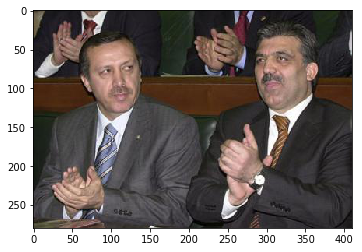

In [11]:
img_path='../data/raw/03/04/img_1190.jpg'
print(os.path.exists(img_path))
img = cv2.imread(img_path)
plt.imshow(convert_to_rgb(img))

Clearly the names don't match here...

In [12]:
for i in range(np.shape(details)[1]):
    cap = str(details[:,i])
    if ('Abdullah Gul' in cap) and ('Burhan Ozbilici' in cap):
        print(cap, "\n")

[ array([[ (array([ "Recep Tayyip Erdogan, leader of Turkey's ruling Justice and Development Party, left, and Turkish <OUT> Prime Minister Abdullah Gul </OUT> applaud during a party meeting in Ankara, Tuesday, March 4, 2003. Erdogan hinted that the government might soon resubmit a motion to parliament authorizing the deployment of tens of thusands of U.S. troops in Turkey, reversing a decision that upset U.S. war plans. Parliament previously rejected a government request to authorize the deployment, unsettling Washington's plans to open a northern front against Iraq. (AP Photo/Burhan Ozbilici)"],
      dtype='<U579'), array(['2003/03/04/img_1190.jpg'],
      dtype='<U23'), array([[array(['Prime Minister Abdullah Gul'],
      dtype='<U27')]], dtype=object))]],
      dtype=[('caption', 'O'), ('picname', 'O'), ('names', 'O')])] 

[ array([[ (array([ "Turkey's <IN> Prime Minister-designate Recep Tayyip </IN> Erdogan, right, and <OUT> Prime Minister Abdullah Gul </OUT> leave the headquarter

[ array([[ (array([ 'Turkish Foreign <IN> Minister Abdullah Gul </IN> speaks to The Associated Press during an exclusive interview in Ankara Tuesday, March 25, 2003. Turkey plans to send its forces up to 12 miles into northern Iraq (news - web sites) to deal with any flood of refugees, but will only move if a crisis develops, Gul said. (AP Photo/Burhan Ozbilici)'],
      dtype='<U343'), array(['2003/03/25/img_889.jpg'],
      dtype='<U22'), array([[array(['Minister Abdullah Gul'],
      dtype='<U21')]], dtype=object))]],
      dtype=[('caption', 'O'), ('picname', 'O'), ('names', 'O')])] 

[ array([[ (array([ 'Turkish Foreign <IN> Minister Abdullah Gul </IN> speaks to the media during a joint news conference with his Israeli counterpart Silvan Shalom, unseen, in Ankara, Turkey, Monday, April 14, 2003. Gul expressed strong reservations about Syria being a possible next target of the coalition forces, saying war in the region should be confined to Iraq (news - web sites). (AP Photo/Burhan

Clearly there are some photographers in the captions, which we do not want to confuse for subjects. We can get round this by cutting the photographer out of each description

In [13]:
cleaned_details = []
for i in range(np.shape(details)[1]):
    #print(details[:,i])
    cleaned_details.append(str(details[:,i].tolist()).split('dtype')[0][:-30])

In [14]:
np.shape(cleaned_details)

(28204,)

In [15]:
cleaned_captions={}
for i in range(np.shape(cleaned_details)[0]):
    cap = str(cleaned_details[i])
    doc = nlp(str(cap))
    people = []
    dates=[]
    for ent in doc.ents:
        if ent.label_=='PERSON' and len(ent.text) > 2:
            name = ent.text
            if name[0]=="'" or name[0]=="\"":
                name=name[1:]
            if name[-1]=="'" or name[-1]=="\"":
                name=name[-1]
            if not name.startswith("array") and len(name)>2:
                people.append(name)
    cap2 = str(details[:,i])
    img_name = cap2.split('.jpg')[0].split('array([\'20')[1]
    if img_name[:2]=='03'and img_name[3:5] in ['01','02','03']:
        cleaned_captions[str(img_name)] = np.unique(people)

In [16]:
cleaned_captions

{'03/01/19/img_592': array(['Actor', 'Downey', 'Robert Downey'],
       dtype='<U13'),
 '03/01/21/img_192': array(['Bush', 'John Snow', 'Kevin Lamarque', "Paul O'Neill", 'Snow'],
       dtype='<U14'),
 '03/03/07/img_1119': array(['Latifah'],
       dtype='<U7'),
 '03/03/04/img_1024': array(['Henri Proglio', 'Proglio'],
       dtype='<U13'),
 '03/02/24/img_635': array(['AP Pho', 'Gerhard Schroeder', 'Jacques Chirac'],
       dtype='<U17'),
 '03/02/18/img_467': array(['Gephardt', 'Richard Gephardt'],
       dtype='<U16'),
 '03/03/06/img_177': array(['Bush', 'George W'],
       dtype='<U8'),
 '03/03/17/img_1137': array(['> Ann Roth', 'Meryl Streep'],
       dtype='<U12'),
 '03/02/03/img_309': array(['Imad Khadduri', 'Khadduri', 'Pho'],
       dtype='<U13'),
 '03/03/04/img_493': array(['Peter Gabriel'],
       dtype='<U13'),
 '03/01/18/img_324': array([], dtype=float64),
 '03/01/23/img_441': array(['Igor Ivanov', 'Ivanov'],
       dtype='<U11'),
 '03/01/19/img_962': array(['Chavez', 'Hugo 

['Festus Mogae', 'Junichiro Koizumi', 'Saddam Hussein']
[array([[ (array([ "Japanese <IN> Prime Minister Junichiro Koizumi </IN> walks into a room to meet Botswana's <OUT> President Festus Mogae </OUT> at his official residence in Tokyo, Thursday, March 20, 2003 as the U.S. deadline for Iraqi leader Saddam Hussein (news - web sites)'s surrender expired and a U.S.-led war became unavoidable. Koizumi was critically attacked Wednesday by opposition party leaders in a parliament debate over his government's decision to support the United States for the war on Iraq (news - web sites). (AP Photo/Ki
[array([[ (array([ "Botswana's <IN> President Festus Mogae </IN> told a rally in Francistown that Health <OUT> Minister Joy Phumaphi </OUT> would become assistant director of the WHO.(AFP/F


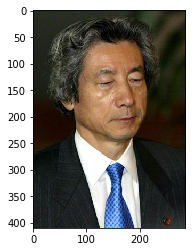

In [17]:
img = cv2.imread('../data/raw/03/19/img_314.jpg')
plt.imshow(convert_to_rgb(img))
names = cleaned_captions['03/03/19/img_314']
print([name for name in names if " " in name])
for d in cleaned_details:
    if ('Festus Mogae' in d):
        print(d)

In [18]:
correctly_detected_clean = {}
correct_positions_clean = {}
for key, value in cleaned_captions.items():
    people = value
    img_path = "../data/raw/%s.jpg"%key[3:]
    img = cv2.imread(img_path)
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = faceDetector.detectMultiScale(img_grey, 1.3, 5)
    posns=[]
    for x,y,w,h in faces:
        posns.append([x,y,w,h])
        #cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    ground_truth_names =  [name for name in value if str(" ") in name] 
    #print("Num detected faces: %d, num ground truth: %d"%(len(faces), len(ground_truth_names)))
    if len(ground_truth_names)==len(faces):
        correctly_detected_clean[key] = value
        print([f_name for f_name in value if " " in f_name])
        correct_positions_clean[key] = posns

['Robert Downey']
['Henri Proglio']
['George W']
['Imad Khadduri']
['Hugo Chavez']
['Christie Whitman']
['Roger Moore']
['> Cameron Diaz']
['Meryl Streep', 'Nicole Kidman']
['Jacques Chirac']
['Tom Ridge']
['Norah Jones']
[]
['Colin Powell']
['George Robertson']
[]
['George W. Bush']
[]
[]
['> Carolyn Dawn Johnson']
['Michael Kostelnik']
['Steve Mariucci']
['Lord Robertson']
['Kevin Spacey']
[]
['2003on Capitol Hill']
['Dick Cheney']
['Alexander Losyukov']
['Karin Viard']
['Julianne Moore', 'Stephen Daldry']
['Steve Mariucci']
['Anna Kournikova']
['Ron Dittemore']
['Dr Nizar Madani']
['Saddam Hussein']
['Donald Rumsfeld', 'George W']
['Laura Bush']
['Gideon Yago']
[]
['Meryl Streep']
['Laura Elena Harring']
['Colin Powell']
['Rob Marshall']
['Tommy Thompson']
['Leonid Kuchma']
['Colin Powell', 'Igor S']
['Pierre Pettigrew']
['George W']
['Edward Norten']
['John Kerry', 'Thomas Menino']
['> Craig David']
['Hugo Chavez']
['Dexter Jackson']
['Alberto Fujimori']
['Takenori Kanzaki']
['Mark

['> Paula Houston']
['Diana Krall']
['Tony Blair']
['Fernando Londono Hoyos', 'Klaus Nyholm']
['Kelvin Sampson']
['George W']
['Saddam Hussein']
['Jacques Chirac']
['Jean Chretien']
['Michele Alliot-']
['Ibrahim Makadmeh', 'Shaul Mofaz']
['Greg Maddux']
['Vladimiro Montesinos']
['Donald Rumsfeld']
['David Checketts']
['Bill Madia']
[]
['> Roy Williams']
['Masahiko Nagasawa', 'Takashi Sorimachi']
['George W. Bush']
['Lina Krasnoroutskaya']
['Alberto Fujimori', 'Vladimiro Montesinos']
['John Bolton']
['Kevin Spacey', 'Vic Theater']
['Colin Powell']
['Michael Chang']
['Carlos Ortega', 'Hugo Chavez', 'Roberto Tovar']
['Julie Gerberding']
['> Bob Hartley']
['Donald Rumsfeld', 'John Howard']
['Sally Clark']
['Minnie Mendoza']
['John McCain', 'Joseph Lieberman']
['Rosalie Perkov']
['Gerhard Schroeder']
['Bill Frist']
['John Timoney']
['John Ashcroft', 'Kellie Greene']
['John Negroponte']
['Christopher Walken']
['Gail Goestenkors']
['George W. Bush']
['John Negroponte']
[]
['Richard Armitage']

['Derek Cianfrance']
['Helen Clarke', 'Simon Crean']
['Jim Harrick']
['Larry Hahn', 'Steve Nesbitt']
['> Shane Warne', 'James Sutherland']
['Robert Zoellick', 'Supachai Panitchpakdi']
['Roman Polanski']
['George Ryan']
['Miguel Estrada']
['Gary Locke']
['Tony Blair']
['> Elisha Cuthbert']
['Alan Schloser', 'Curtis Rodriguez']
['Darren Lehmann', 'Ricky Ponting']
['Gary Forsee']
['Tony La']
['David Davies']
['Bhumibol Adulyadej']
['Natalie Cole']
['Howard Stern']
['George W']
['B.B. King']
[]
['Jose Maria Aznar']
['Hugo Chavez']
['Brad Brownell']
['Abdullah Gul']
[]
['Rachel Wheatley']
['Richard Sterner']
['Lubomir Zaoralek', 'Vaclav Havel', 'Vladimir Spidla']
['Jacques Chirac']
['John Snow']
[]
[]
['Gerhard Boekel']
['> Roy Williams']
[]
['Vladimir Putin']
['Colin Powell']
['Mike Cunning']
['Lindsay Davenport']
['Maria de Jesus']
['John Negroponte']
['Stephan Eberharter']
['George W. Bush', 'Tommy Thompson']
['John Manley']
['Donald Rumsfeld']
['Meryl Streep', 'Nicole Kidman']
['Saddam 

['Jean Chretien']
['Andy Clark', 'Colleen Atwood']
['Jean Chretien']
[]
['Brian David Mitchell', 'Wanda Barzee']
['Michelle Kwan']
['John W']
['Yoriko Kawaguchi']
['Eric Clapton']
['Colin Powell']
['Clarence Weatherspoon']
['Kofi Annan']
['John Snow']
['Kristin Chenoweth', 'Matthew Broderick']
['Woodrow Stanley']
['Stephen Daldry']
['Tom Coverdale']
['Lute Olson']
['John Negroponte']
['Tom Christerson']
['Junichiro Koizumi']
['Recep Tayyip']
['George W', 'John Snow']
['Saddam Hussein']
['George W. Bush']
['Michael Katzenberg']
['Delegate Afif']
['Hugo Chavez']
['Jean Chretien']
['Michael Keaton']
[]
['George Bush', 'Jose Maria Aznar', 'Tony Blair']
['Davey Johnson', 'Gary Carter']
['Sean Connery']
['Claudia Schiffer']
['Michael Jackson']
['Barry Zito']
['Kieran Culkin']
['Waqar Younis']
['Timothy Goebel']
['Peter Chan']
['Natalie Cole']
['Jean-Pierre Raffarin']
['Colin Powell']
['Carlos Morales', 'Laura Bush']
['Melanie Turgeon']
['George W']
['Miguel Estrada']
['Jan Peter Balkenende']

['Steve Mariucci']
['Janez Drnovsek']
['Ari Fleischer']
['> Jack Nicholson']
['Martha Burk']
[]
['Norah Jones']
['Ron Dittemore']
["Sean O'Keefe"]
['Jean Chretien', 'John Manley']
['Kevin Millar']
['French Stewart']
['Bill Graham']
['George Bush', 'Jose Maria Aznar']
['Martin Sheen']
['Mahathir Mohamad']
['Joshua Gracin']
['John Joungwoong', 'Victor B', 'William Genego']
['Michael Jordan']
['Gerhard Schroeder']
['Vlado Buckovski']
['Hooters Air', 'Robert Brooks']
['> Bob Hope']
['Freddy Garcia']
['Saddam Hussein']
['Colin Powell']
['John W']
[]
['Gray Davis']
['Renee Zellweger']
['> Boris Jordan']
['Gary Bettman']
['Jean Chretien']
['Hamid Karzai']
['John Negroponte']
['Garry Trudeau']
['Harry Schmidt', 'William Umbach']
['Julianne Moore']
['James Gandolfini']
['Alfredo Moreno']
['Stephen Oake']
['Ariel <']
['Andrew Jarecki']
['Prince Harry']
['Peter Brabeck']
['Megan Mullally']
['Catherine Zeta-', 'Renee Zellweger']
['Edward Norton']
['George W']
['Jon Gruden']
['Jacques Chirac']
['Co

['R. Glenn']
['John Snow']
['> Paul Gascoigne']
['Alberto Fujimori']
['Jerry Sexton', 'John Nimmo']
['Donald H. Rumsfeld']
['Rick Pitino']
['Colin Powell']
['Julianne Moore']
['Michelle Collins']
['Biljana Plavsic']
['Robert Beck']
['Gerhard Schroeder', 'Jacques Chirac']
['Jason Whitten']
['Tom Daschle']
['> Elizabeth Pena']
['Hugo Chavez', 'Juan Fernandez']
[]
['Renee Zellweger']
['Amram Mitzna', 'Ariel <']
['Sarah Hughes']
['Saddam Hussein']
['Aleksander Voloshin', 'Colin Powell']
['Rob Ray']
['Pauline Hanson']
['Tom Christerson']
['Standard Time']
['Juan Carlos']
['Jack Straw', 'Kamal Kharrazi']
['John E. Potter']
['Lindsay Davenport']
['Colin Powell']
['Joschka Fischer', 'Laszlo Kovacs']
['Megan Mullally']
['John Ritter']
['John Snow']
['> Paul Graham']
['Linda Mason']
['Steve Largent']
['Colin Powell']
['Laura Bush']
['Manuel Medina']
['Lloyd Ward']
['Steven Seagal']
['Bill Graham']
['Ewan McGregor', 'Renee Zellweger']
['Richard Armitage']
[]
['John Kerry']
['Jim Phelan']
['Carl R

At this stage we haven't taken out the single word names, becuase spacy's entity extractor often shortens names like 'President Bush' to 'Bush'

In [19]:
len(correctly_detected)

1117

In [20]:
print("Name: ",correctly_detected['03/01/19/img_962'])
print("Face location: ",correct_positions['03/01/19/img_962'])

Name:  ['Chavez' 'Hugo Chavez']
Face location:  [[84, 62, 205, 205]]


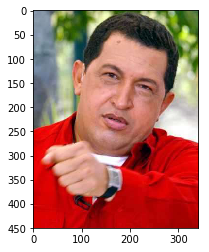

In [21]:
img2 = cv2.imread('../data/raw/01/19/img_962.jpg')
plt.imshow(convert_to_rgb(img2))

The experiement can now be re-run using this new knowledge. Ideally we would have a few faces, with many examples of each, to train the ML algorithm. However, this may not be the case - it is worth looking at the statistics of our training data before moving on to the next experiment.

In [22]:
list(correctly_detected_clean)

['03/01/19/img_592',
 '03/03/04/img_1024',
 '03/03/06/img_177',
 '03/02/03/img_309',
 '03/01/19/img_962',
 '03/01/15/img_244',
 '03/02/06/img_931',
 '03/03/23/img_672',
 '03/01/17/img_467',
 '03/02/17/img_660',
 '03/01/22/img_356',
 '03/02/23/img_187',
 '03/02/11/img_417',
 '03/02/05/img_799',
 '03/01/22/img_976',
 '03/03/19/img_374',
 '03/01/29/img_895',
 '03/02/25/img_1093',
 '03/02/10/img_170',
 '03/01/13/img_358',
 '03/02/05/img_776',
 '03/02/05/img_325',
 '03/02/20/img_613',
 '03/02/05/img_1112',
 '03/03/26/img_429',
 '03/01/28/img_262',
 '03/03/16/img_891',
 '03/01/18/img_964',
 '03/02/23/img_1307',
 '03/03/02/img_428',
 '03/01/13/img_630',
 '03/03/03/img_816',
 '03/02/03/img_267',
 '03/01/14/img_924',
 '03/03/06/img_207',
 '03/03/25/img_581',
 '03/02/20/img_440',
 '03/02/23/img_1012',
 '03/03/20/img_1345',
 '03/02/23/img_946',
 '03/01/19/img_670',
 '03/01/28/img_500',
 '03/02/06/img_785',
 '03/02/26/img_617',
 '03/03/26/img_1129',
 '03/01/20/img_734',
 '03/02/25/img_470',
 '03/0